In [1]:
import os
os.chdir("C:\\Users\\tsarcevic\\PycharmProjects\\fingerprinting-toolbox")
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pickle
import numpy as np
import pandas as pd
import collections
from pprint import pprint

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

from scipy.stats import chi2
from matplotlib import pyplot

from datasets import Nursery

In [4]:
with open('parameter_guidelines/Nursery/evaluation/rel_vertical_attack_utility_loss_gb_fpattr8.pickle', 'rb') as infile:
    utility_loss_20 = pickle.load(infile)

In [5]:
np.mean([np.mean(ut) for ut in utility_loss_20[1]])

-0.5335574683723584

In [29]:
with open('parameter_guidelines/Nursery/evaluation/robustness_vertical_universal_c95_e30.pickle', 'rb') as infile:
    robustness = pickle.load(infile)

In [30]:
robustness

{1: 0.75,
 1.11: 0.75,
 1.25: 0.75,
 1.43: 0.75,
 1.67: 0.75,
 2: 0.75,
 2.5: 0.75,
 3: 0.75,
 4: 0.62,
 5: 0.62,
 10: 0.5,
 18: 0.38}

In [11]:
gamma=1
fp_dir = "parameter_guidelines/fingerprinted_data/nursery/attr_subset_8/"
fingerprinted_data = pd.read_csv(fp_dir + "universal_g{}_x1_l32_u1_sk0.csv".format(gamma))
data = Nursery().preprocessed(fp_data=fingerprinted_data)

In [12]:
X_fp = data.drop('target', axis=1)
y_fp = data['target']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_fp, y_fp, test_size=0.2, random_state=9)

model = GradientBoostingClassifier()
model.fit(X_train, y_train)
acc = accuracy_score(y_test, model.predict(X_test))

In [14]:
acc

0.8452932098765432

In [15]:
#model = GradientBoostingClassifier(random_state=9)
#original = cross_val_score(model, X_fp, y_fp)
#original

array([0.70987654, 0.65933642, 0.7341821 , 0.69625627, 0.63952142])

In [18]:
model.feature_importances_

array([0.07909748, 0.19361998, 0.00585532, 0.01022164, 0.01379173,
       0.00584065, 0.01305558, 0.67851763])

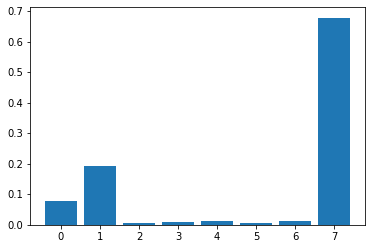

In [19]:
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [20]:
feature_importances = dict(zip(data.columns, model.feature_importances_))
feature_importances

{'parents': 0.07909747616821541,
 'has_nurs': 0.19361997568442604,
 'form': 0.005855323074272755,
 'children': 0.010221641598791933,
 'housing': 0.013791726172105905,
 'finance': 0.005840648394091483,
 'social': 0.013055583006951641,
 'health': 0.6785176259011448}

In [21]:
def drop_least_important(n, features):
    remaining = features
    for i in range(n):
        min_val = min(remaining.values())
        remaining = {k: v for k, v in remaining.items() if v != min_val}    
    return remaining

In [22]:
selected_f = drop_least_important(5, feature_importances)

In [23]:
removed = list(feature_importances.keys() - selected_f.keys())

In [24]:
X_fp = data.drop('target', axis=1)
X_fp = X_fp.drop(removed, axis=1)
print(len(X_fp.columns))
y_fp = data['target']

3


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_fp, y_fp, test_size=0.2, random_state=9)

model = GradientBoostingClassifier()
model.fit(X_train, y_train)
acc = accuracy_score(y_test, model.predict(X_test))

In [26]:
acc

0.8101851851851852

In [27]:
model = GradientBoostingClassifier(random_state=9)
removed_25p = cross_val_score(model, X_fp, y_fp)
removed_25p

array([0.73842593, 0.65354938, 0.65625   , 0.6341181 , 0.62755693])

In [28]:
np.mean(removed_25p), np.mean(original)

(0.6619800675176656, 0.6878345507478404)

## Experiment

In [38]:
fp_dir = "parameter_guidelines/fingerprinted_data/nursery/attr_subset_8/"
results = dict()
original = dict()
for gamma in robustness:
    fingerprinted_data = pd.read_csv(fp_dir + "universal_g{}_x1_l32_u1_sk0.csv".format(gamma))
    data = Nursery().preprocessed(fp_data=fingerprinted_data)
    
    #split
    X_fp = data.drop('target', axis=1)
    y_fp = data['target']
    # original accuracy
    model = GradientBoostingClassifier(random_state=9)
    original[gamma] = cross_val_score(model, X_fp, y_fp)
    print('original acc: ', np.mean(original[gamma]))
    
    # 
    to_remove = int(8*robustness[gamma])+1
    selected_f = drop_least_important(to_remove, feature_importances)
    removed = list(feature_importances.keys() - selected_f.keys())
    X_fp = data.drop('target', axis=1)
    X_fp = X_fp.drop(removed, axis=1)
    print(len(X_fp.columns))
    print(X_fp.columns)
    y_fp = data['target']
    model = GradientBoostingClassifier(random_state=9)
    acc = cross_val_score(model, X_fp, y_fp)
    print('selected accuracy: ', np.mean(acc))
    results[gamma] = acc

original acc:  [0.70987654 0.65933642 0.7341821  0.69625627 0.63952142]
1
Index(['health'], dtype='object')
selected accuracy:  [0.6257716  0.6408179  0.66936728 0.67502895 0.70281745]
original acc:  [0.71604938 0.65625    0.74228395 0.68776534 0.64067927]
1
Index(['health'], dtype='object')
selected accuracy:  [0.63117284 0.64390432 0.67283951 0.67927441 0.70899267]
original acc:  [0.72299383 0.65972222 0.74382716 0.6912389  0.64183713]
1
Index(['health'], dtype='object')
selected accuracy:  [0.63387346 0.64737654 0.67824074 0.68120417 0.71208028]
original acc:  [0.72029321 0.66782407 0.7503858  0.68622154 0.63720571]
1
Index(['health'], dtype='object')
selected accuracy:  [0.63927469 0.65200617 0.68209877 0.68660749 0.7174836 ]
original acc:  [0.74266975 0.6882716  0.75964506 0.69471247 0.63681976]
1
Index(['health'], dtype='object')
selected accuracy:  [0.64544753 0.65393519 0.68479938 0.69394056 0.72095716]
original acc:  [0.76967593 0.69251543 0.76658951 0.72674643 0.64260903]
1
I

In [44]:
original_acc = {1: 0.7405195473251028,
 1.11: 0.7398842592592594,
 1.25: 0.7300977366255145,
 1.43: 0.7180684156378601,
 1.67: 0.7149819958847736,
 2: 0.7208101851851851,
 2.5: 0.723996913580247,
 3: 0.7207355967078188,
 4: 0.7147968106995884,
 5: 0.7057175925925926,
 10: 0.6799717078189301,
 18: 0.6590509259259262}

In [46]:
rel_loss_temp = dict()
for gamma in results:
    loss = original_acc[gamma] - results[gamma] 
    rel_loss_temp[gamma] = loss / original_acc[gamma]

In [39]:
rel_loss = dict()
for gamma in results:
    loss = original[gamma] - results[gamma] 
    rel_loss[gamma] = loss / original[gamma]

In [47]:
rel_loss

{1: array([ 0.11847826,  0.0280866 ,  0.08828166,  0.0304878 , -0.09897405]),
 1.11: array([ 0.11853448,  0.01881246,  0.09355509,  0.01234568, -0.10662651]),
 1.25: array([ 0.12326574,  0.01871345,  0.08817427,  0.01451703, -0.10944077]),
 1.43: array([ 0.11247991,  0.02368573,  0.09100257, -0.00056243, -0.12598425]),
 1.67: array([ 0.13090909,  0.04988789,  0.09852717,  0.00111111, -0.13212121]),
 2: array([ 0.15488722,  0.04791086,  0.1016608 ,  0.04036113, -0.12852853]),
 2.5: array([ 0.148     ,  0.06706328,  0.09021794,  0.00979858, -0.15651644]),
 3: array([ 0.12849162,  0.07100592,  0.08240081, -0.00717835, -0.1948782 ]),
 4: array([0.13435796, 0.17184943, 0.20049505, 0.11864407, 0.00359066]),
 5: array([ 0.14348678,  0.3408    ,  0.19761668,  0.13752665, -0.02770936]),
 10: array([ 0.15961538,  0.19004764,  0.23124406,  0.14005305, -0.0036036 ]),
 18: array([0.12202236, 0.03366446, 0.14885496, 0.10782789, 0.10864346])}

In [50]:
with open('parameter_guidelines/Nursery/evaluation/rel_targeted_vertical_attack_utility_loss_gb_sk0.pkl', 'wb') as outfile:
    pickle.dump(rel_loss_temp, outfile) 